In [60]:
import tempfile

import torch as t
from rich.pretty import pprint as pp
from tensordict import TensorDict, tensorclass
from torchrl.data import LazyMemmapStorage, LazyTensorStorage, ListStorage, ReplayBuffer

In [2]:
buffer = ReplayBuffer()

In [3]:
print("length before adding elements:", len(buffer))

buffer.extend(range(2000))

print("length after adding elements:", len(buffer))

length before adding elements: 0
length after adding elements: 1000


In [5]:
buffer.sample(5)

tensor([1058, 1020, 1942, 1441, 1901])

In [92]:
size = 100 # We define the maximum size of the buffer

buffer_list = ReplayBuffer(storage=ListStorage(size), collate_fn=lambda x: x)
buffer_list.extend(["a", 0, "b"])
print(buffer_list.sample(3))

['b', 0, 0]


In [93]:
buffer_lazytensor = ReplayBuffer(storage=LazyTensorStorage(size))

In [94]:
data = TensorDict(
    {
        "a": t.arange(12).view(3, 4),
        ("b", "c"): t.arange(15).view(3, 5),
    }, # type: ignore
    batch_size=[3],
)
pp(data)

TensorDict(
│   fields={
│   │   a: Tensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.int64, is_shared=False),
│   │   b: TensorDict(
│   │   │   fields={
│   │   │   │   c: Tensor(shape=torch.Size([3, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
│   │   │   batch_size=torch.Size([3]),
│   │   │   device=None,
│   │   │   is_shared=False)},
│   batch_size=torch.Size([3]),
│   device=None,
│   is_shared=False)

In [29]:
buffer_lazytensor.extend(data) # type: ignore
print(f"The buffer has {len(buffer_lazytensor)} elements")

The buffer has 3 elements


In [30]:
sample = buffer_lazytensor.sample(5)
pp(("samples", sample["a"], sample["b", "c"]))

(
│   'samples',
│   tensor([[ 8,  9, 10, 11],
│   │   [ 4,  5,  6,  7],
│   │   [ 8,  9, 10, 11],
│   │   [ 8,  9, 10, 11],
│   │   [ 8,  9, 10, 11]]),
│   tensor([[10, 11, 12, 13, 14],
│   │   [ 5,  6,  7,  8,  9],
│   │   [10, 11, 12, 13, 14],
│   │   [10, 11, 12, 13, 14],
│   │   [10, 11, 12, 13, 14]])
)

In [34]:
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size))
buffer_lazymemmap.extend(data) # type: ignore
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazytensor.sample(5)
pp(sample)

The buffer has 3 elements


TensorDict(
│   fields={
│   │   a: Tensor(shape=torch.Size([5, 4]), device=cpu, dtype=torch.int64, is_shared=False),
│   │   b: TensorDict(
│   │   │   fields={
│   │   │   │   c: Tensor(shape=torch.Size([5, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
│   │   │   batch_size=torch.Size([5]),
│   │   │   device=cpu,
│   │   │   is_shared=False)},
│   batch_size=torch.Size([5]),
│   device=cpu,
│   is_shared=False)

In [91]:
tempdir = tempfile.TemporaryDirectory()
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size, scratch_dir=tempdir))
buffer_lazymemmap.extend(data)  # type: ignore
print(f"The buffer has {len(buffer_lazymemmap)} elements")
print("the 'a' tensor is stored in", buffer_lazymemmap._storage._storage["a"].filename) # type: ignore
print(
    "the ('b', 'c') tensor is stored in",
    buffer_lazymemmap._storage._storage["b", "c"].filename, # type: ignore
)

The buffer has 12 elements


ValueError: Invalid indexing arguments: a.

In [37]:
pp(buffer_lazymemmap)

ReplayBuffer(
│   storage=LazyMemmapStorage(
│   │   data=TensorDict(
│   │   │   fields={
│   │   │   │   a: MemoryMappedTensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.int64, is_shared=True),
│   │   │   │   b: TensorDict(
│   │   │   │   │   fields={
│   │   │   │   │   │   c: MemoryMappedTensor(shape=torch.Size([3, 5]), device=cpu, dtype=torch.int64, is_shared=True)},
│   │   │   │   │   batch_size=torch.Size([3]),
│   │   │   │   │   device=cpu,
│   │   │   │   │   is_shared=False)},
│   │   │   batch_size=torch.Size([3]),
│   │   │   device=cpu,
│   │   │   is_shared=False), 
│   │   shape=torch.Size([3]), 
│   │   len=3, 
│   │   max_size=100), 
│   sampler=RandomSampler(), 
│   writer=RoundRobinWriter(cursor=3, full_storage=False), 
│   batch_size=None, 
│   collate_fn=<function _collate_id at 0x7efe0c532ac0>)

In [53]:
from torchrl.data import TensorDictReplayBuffer

tempdir = tempfile.TemporaryDirectory()
buffer_lazymemmap = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir=tempdir), batch_size=12
)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazymemmap.sample()
pp(sample)

The buffer has 3 elements


TensorDict(
│   fields={
│   │   a: Tensor(shape=torch.Size([12, 4]), device=cpu, dtype=torch.int64, is_shared=False),
│   │   b: TensorDict(
│   │   │   fields={
│   │   │   │   c: Tensor(shape=torch.Size([12, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
│   │   │   batch_size=torch.Size([12]),
│   │   │   device=cpu,
│   │   │   is_shared=False),
│   │   index: Tensor(shape=torch.Size([12]), device=cpu, dtype=torch.int64, is_shared=False)},
│   batch_size=torch.Size([12]),
│   device=cpu,
│   is_shared=False)

In [59]:
sample["index"]

tensor([2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1])

In [67]:
@tensorclass  # type: ignore
class MyData:
    images: t.Tensor
    labels: t.Tensor


data = MyData(images=t.randint(255, (10, 64, 64, 3)), labels=t.randint(100, (10,)), batch_size=[10])  # type: ignore

In [68]:
tempdir = tempfile.TemporaryDirectory()
buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir=tempdir), batch_size=12
)
buffer_lazymemmap.extend(data)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [113]:
from torchrl.data.replay_buffers.samplers import PrioritizedSampler

size = 100

rb = ReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(max_capacity=size, alpha=0.8, beta=1.1),
    collate_fn=lambda x: x,
)

In [76]:
indices = rb.extend([1, "foo", None])

In [88]:
rb.update_priority(index=indices, priority=t.tensor([3, 0.1, 0.1]))

In [89]:
sample, info = rb.sample(10, return_info=True)

In [90]:
sample

[1, 1, None, 1, 1, 1, 1, 1, 1, 1]

In [114]:
rb = TensorDictReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(size, alpha=0.8, beta=1.1),
    priority_key="td_error",
    batch_size=1024,
)

In [115]:
data["td_error"] = t.arange(data.numel())
rb.extend(data)
sample = rb.sample()

(array([338.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 686.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

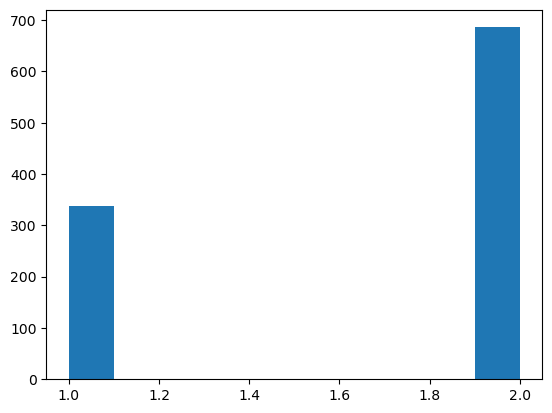

In [116]:
from matplotlib import pyplot as plt

plt.hist(sample["index"].numpy())

In [117]:
sample = rb.sample()
sample["td_error"] = data.numel() - sample["index"]

In [118]:
rb.update_tensordict_priority(sample)

(array([638.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 386.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

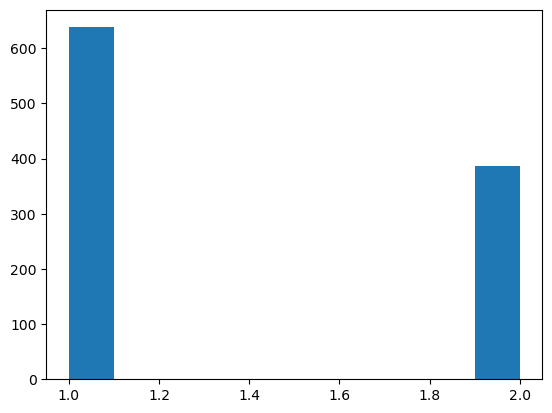

In [126]:
sample = rb.sample()

plt.hist(sample["index"].numpy())